In [311]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

In [312]:
# Load data
df = pd.read_csv('SMDG_results.csv')

# Randomly shuffle data
df = df.sample(frac=1, ignore_index=True)

# Remove rows with missing values
df = df.dropna()

# Remove rows where glaucoma is not 0 or 1
# df = df[df['glaucoma'].isin([0, 1])]

# Remove unnecesary columns
# keep = ['filename', 'glaucoma'] + [col for col in df.columns if 'pcdr_' in col]
delta_ang = 5
keep = ['filename', 'glaucoma'] + ['pcdr_' + str(i) for i in range(0, 360, delta_ang)]
df = df[keep]

# Keep pcdr_ columns every 2
df = df.iloc[:, [0, 1] + list(range(2, df.shape[1], 2))]

# Remove rows with 'glaucoma' equal to -1
df = df[df['glaucoma'] != -1]

# Keep only rows with filename starting with 'ORIGA'
# df = df[df['filename'].str.startswith('ORIGA')]

# Cap pcdr_ values to 1
# df[df.iloc[:, 2:] > 1] = 1

# Keep only rows that have pcdr_ values (lb, ub]
lb = 0 ; ub = 1
df = df[(df.iloc[:, 2:] <= lb).any(axis=1).__invert__() & (df.iloc[:, 2:] > ub).any(axis=1).__invert__()]

# Remove rows with all pcdr_ values equal to 1
df = df[(df.iloc[:, 2:] == 1).all(axis=1).__invert__()]

# Split data into train and test
seed = np.random.randint(0, 10000)
np.random.seed(seed)
train = df.sample(frac=0.7)
test = df.drop(train.index)
print('Train:', train.shape[0])
print('Test:', test.shape[0])
print('#############################################')
print('Images suitable for analysis:', df.shape[0])
print('Glaucoma:', (df['glaucoma'] == 1).sum())
print('Non glaucoma:', (df['glaucoma'] == 0).sum())
print('Glaucoma-suspect:', (df['glaucoma'] == -1).sum())

Train: 5312
Test: 2276
#############################################
Images suitable for analysis: 7588
Glaucoma: 2748
Non glaucoma: 4840
Glaucoma-suspect: 0


**Disclaimer**

- Disc, cup and fovea segmentations are done using segmentation CNNs. Very useful for large batches of data but can generate some weird segmentations, especially in low quality fundus images.

**Excluding rules**

- All pCDR values == 1: ellipses fitted to cup and disc segmentations are equal or almost equal.
  
- pCDR values very low: generally caused by the disc segmentation not being great (disc surrounding tissue, pathology near disc, disc edge barely visible...).
  
- pCDR values > 1: disc and cup ellipses are very very close together and, mathematically, the calculation of the intersection points leads to the cup_points going over the disc_points.

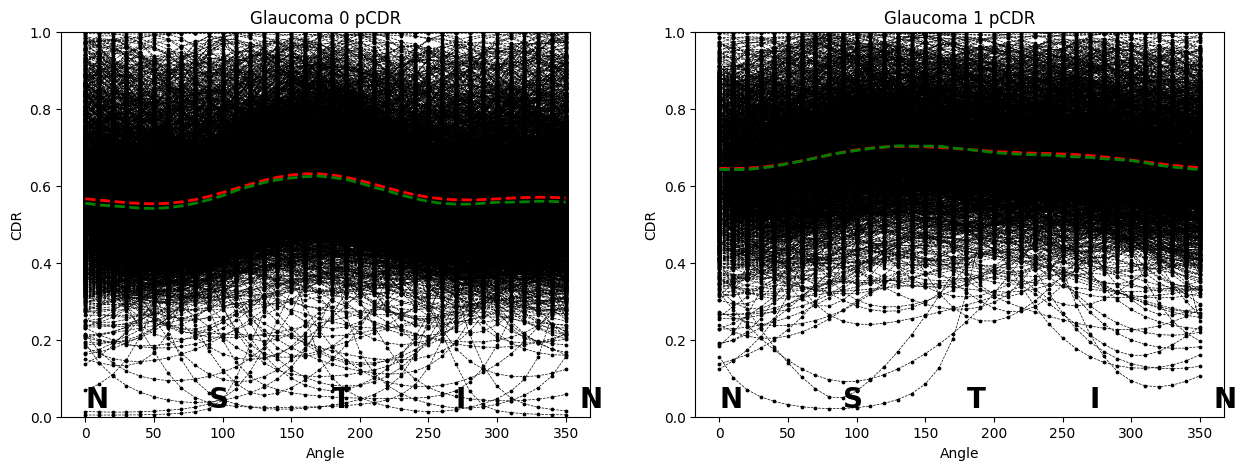

In [313]:
# Group by glaucoma status
df_grouped = train.groupby('glaucoma')

# Plot pcdr values
plt.figure(figsize=(15, 5))
# Number of groups to plot
n_groups = len(df_grouped)
for i, (name, group) in enumerate(df_grouped):
    plt.subplot(1, n_groups, i + 1)
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(angles, cdr, 'k--', linewidth=0.5)
    plt.scatter(angles, cdr, s=3, c='k')
    
    # Plot mean and median
    mean_cdr = np.mean(cdr, axis=1)
    median_cdr = np.median(cdr, axis=1)
    plt.plot(angles[:, 0], mean_cdr, 'r--', linewidth=2)
    plt.plot(angles[:, 0], median_cdr, 'g--', linewidth=2)
    
    # Overlay N S T I N labels on top of the X axis
    angle = [0, 90, 180, 270, 360]
    quadrant = ['N', 'S', 'T', 'I', 'N']
    for a, q in zip(angle, quadrant):
        plt.text(a, 0.025, q, fontsize=20, color='k', fontweight='bold')
    
    plt.title(f'Glaucoma {name} pCDR')
    plt.xlabel('Angle')
    plt.ylabel('CDR')
    plt.ylim(0, 1)
    
plt.show()

## Fourier Analysis of signals

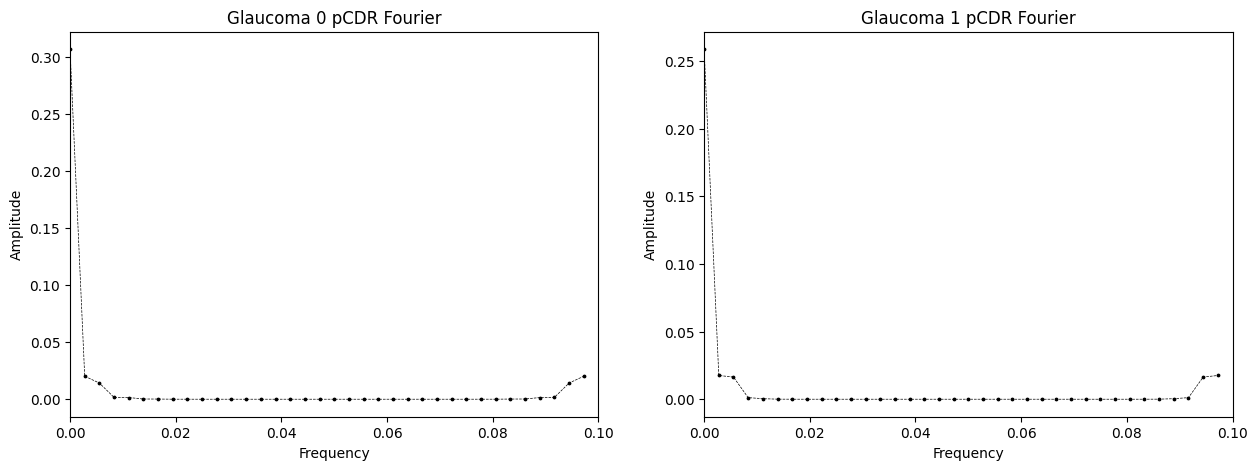

In [332]:
from numpy.fft import fft, fftfreq

# Fourier frequencies
freq = fftfreq(int(360/delta_ang), delta_ang)
freq = freq[freq >= 0]

# Compute Fourier transform
train_fft = fft(train.iloc[:, 2:], axis=1)
train_fft = np.abs(train_fft) / (360/delta_ang)

# Plot frequency spectrum
# TODO: make a boxplot of amplitudes for each frequency
plt.figure(figsize=(15, 5))
for i, (name, group) in enumerate(df_grouped):
    plt.subplot(1, n_groups, i + 1)
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(freq, train_fft[i], 'k--', linewidth=0.5)
    plt.scatter(freq, train_fft[i], s=3, c='k')
    
    plt.title(f'Glaucoma {name} pCDR Fourier')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.xlim(0, 0.1)


## Mahalanobis

In [314]:
# Define method to calculate Mahalanobis distance
def mahalanobis(x, mu, cov):
    """
    Calculate Mahalanobis distance between two vectors x and mu using covariance matrix cov.
    
    Parameters
    ----------
    x : (N,M) array_like
        Input array.
    mu : (N,) array_like
        Mean vector of the distribution.
    cov : (N,N) array_like
        Covariance matrix of the distribution.
        
    """
    
    inv_cov = np.linalg.inv(cov)
    delta = x - mu
    # m = np.dot(np.dot(delta, inv_cov), delta.T)
    m = delta @ inv_cov @ delta.T
    out = np.sqrt(m.diagonal())
    return out

# Calculate Mahalanobis distance for each group
cov_matrices = {}
mean_vectors = {}
for name, group in df_grouped:
    # Covariance matrix
    cov = np.cov(group.iloc[:, 2:].values.T)
    # Add covariance matrix to dictionary
    cov_matrices.update({name: cov})
    # Add mean vector to dictionary
    mean_vectors.update({name: np.mean(group.iloc[:, 2:].values, axis=0)})

Prior probability of glaucoma: 0.3510918674698795
Log prior odds: -0.6142432344389495
#############################################


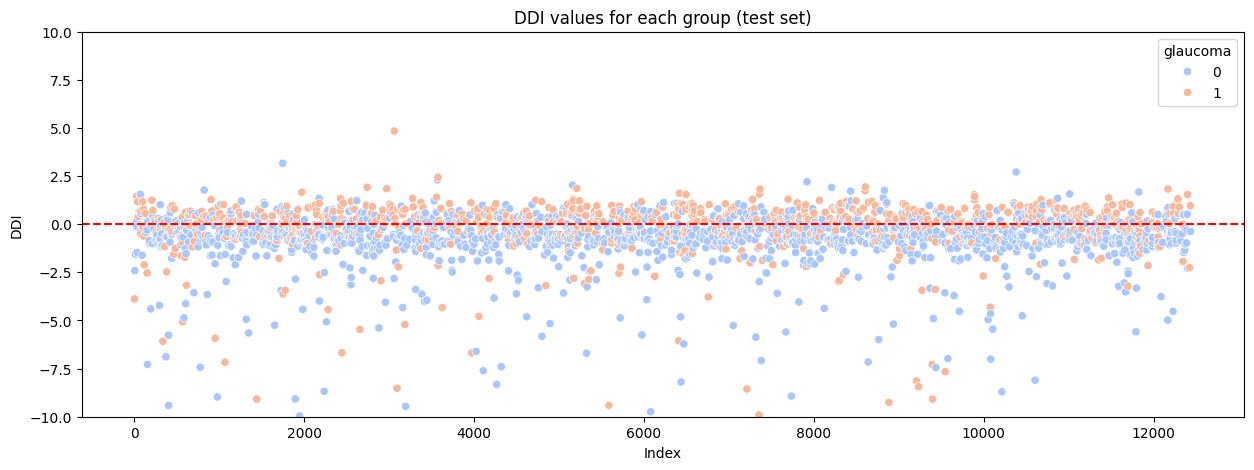

In [315]:
# Calculate Mahalanobis distance on test for each group
test2 = pd.DataFrame(index=test.index)
for k, v in cov_matrices.items():
    mu = mean_vectors.get(k)
    x = test.iloc[:, 2:].values
    # Add Mahalanobis distance to test2
    col_name = f'mahalanobis_{k}'
    test2[col_name] = mahalanobis(x=x, mu=mu, cov=v)
    
# Prior probability of glaucoma
prior_glaucoma = (train['glaucoma'] == 1).sum() / train.shape[0] # ((train['glaucoma'] == 1).sum() + (train['glaucoma'] == 0).sum())
log_prior_odds = np.log(prior_glaucoma / (1 - prior_glaucoma))
print('Prior probability of glaucoma:', prior_glaucoma)
print(f'Log prior odds: {log_prior_odds}')
print('#############################################')

# log(posterior odds) = log(prior odds) + 0.5 * (mahalanobis_0 - mahalanobis_1)
DDI = test2['mahalanobis_0'] - test2['mahalanobis_1']
# test2['log_posterior_odds'] = log_prior_odds + 0.5 * DDI

# # Posterior probability of glaucoma
# test2['posterior_probability'] = 1 / (1 + np.exp(-test2['log_posterior_odds']))

# # Scatter plot of posterior probability of suspected glaucoma
# plt.figure(figsize=(15, 5))
# sns.scatterplot(x=test2.index, y=test2['posterior_probability'], hue=test['glaucoma'], palette='coolwarm')
# plt.ylim(0, 1)
# plt.xlabel('Index')
# plt.ylabel('Probability of glaucoma')
# plt.title('Posterior probability of patients (test set)')

# Plot DDI values for each group
plt.figure(figsize=(15, 5))
sns.scatterplot(x=test2.index, y=DDI, hue=test['glaucoma'], palette='coolwarm')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('DDI')
plt.title('DDI values for each group (test set)')
plt.ylim(-10, 10)
plt.show()

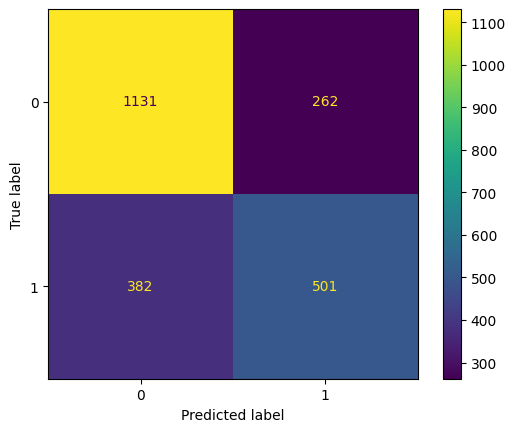

In [316]:
from sklearn.metrics import ConfusionMatrixDisplay

# Add DDI to test
test2['DDI'] = DDI

# Classification based on DDI
threshold = 0
test2['predicted_glaucoma'] = np.where(test2['DDI'] > threshold, 1, 0)

# Confusion matrix
y_true = test['glaucoma']
y_pred = test2['predicted_glaucoma']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

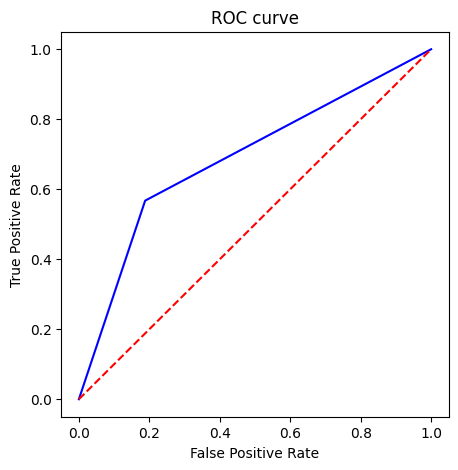

In [317]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# LME (Linear Mixed Effects) modelling

In [318]:
# Create a dataframe with column names ['filename', 'glaucoma', 'angle', 'pcdr']
train_mdl = pd.DataFrame(columns=['filename', 'glaucoma', 'angle', 'pcdr'])

# Initialize a list to collect new rows
new_rows = []

for i, row in train.iterrows():
    # Get filename and glaucoma status
    filename = row['filename']
    glaucoma = row['glaucoma']
    # Iterate over each angle
    for id, col in enumerate(train.columns[2:]):
        angle = int(col.split('_')[1])
        pcdr = row[col]
        # Add data to the list of new rows
        new_rows.append({'filename': filename, 'glaucoma': glaucoma, 'angle': angle, 
                         'd':angle/5 + 1, 'd_id': id, 
                         'pcdr': pcdr}) 

# Create a new DataFrame from the list of new rows
train_mdl = pd.DataFrame(new_rows)
        
train_mdl

,filename,glaucoma,angle,d,d_id,pcdr
0,EyePACS-Glaucoma-2570.png,1,0,1.0,0,0.531281
1,EyePACS-Glaucoma-2570.png,1,10,3.0,1,0.512395
2,EyePACS-Glaucoma-2570.png,1,20,5.0,2,0.497250
3,EyePACS-Glaucoma-2570.png,1,30,7.0,3,0.486787
4,EyePACS-Glaucoma-2570.png,1,40,9.0,4,0.482243
...,...,...,...,...,...,...
191227,EyePACS-Glaucoma-1318.png,1,310,63.0,31,0.741819
191228,EyePACS-Glaucoma-1318.png,1,320,65.0,32,0.742920
191229,EyePACS-Glaucoma-1318.png,1,330,67.0,33,0.744688
191230,EyePACS-Glaucoma-1318.png,1,340,69.0,34,0.746527


In [319]:
formula = f'pcdr ~ 1 + np.sin(2*np.pi*d/{360/delta_ang}) + np.cos(2*np.pi*d/{360/delta_ang}) + np.sin(4*np.pi*d/{360/delta_ang}) + np.cos(4*np.pi*d/{360/delta_ang})'

# Mixed LM model
model = smf.mixedlm(formula, train_mdl, groups=train_mdl['glaucoma'],)
                    # re_formula='1', vc_formula={'glaucoma:d_id': '0 + C(d_id)'})

# Fit the model
result = model.fit()

# Print the summary
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      pcdr       
No. Observations:      191232       Method:                  REML       
No. Groups:            2            Scale:                   0.0157     
Min. group size:       67140        Log-Likelihood:          125760.6165
Max. group size:       124092       Converged:               Yes        
Mean group size:       95616.0                                          
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     0.629    0.089   7.098 0.000  0.455  0.803
np.sin(2 * np.pi * d / 72.0)  0.002    0.000   4.814 0.000  0.001  0.003
np.cos(2 * np.pi * d / 72.0) -0.029    0.000 -71.560 0.000 -0.030 -0.028
np.sin(4 * np.pi * d / 72.0) -0.008    0.000 -19.044 0.000 -0.009 -0.

/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
